In [1]:
#Evaluate ACCESS-OM2-01 IAF Properties along 110E
#https://cchdo.ucsd.edu/search?bbox=105,-90,115,-50

In [2]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath

In [3]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:33091 Dashboard: /proxy/37633/status,Cluster Workers: 8 Cores: 8 Memory: 100.00 GiB


In [4]:
#load woa13 T/S data
woa13=xr.open_mfdataset('/g/data/hh5/tmp/cosima/woa13/01/output000/woa13_ts_*.nc',engine='netcdf4',decode_times=False)
woa13

<xarray.Dataset>
Dimensions:   (GRID_X_T: 3600, GRID_Y_T: 2700, ZT: 75, time: 12)
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * GRID_Y_T  (GRID_Y_T) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * ZT        (ZT) float64 0.5413 1.681 2.94 ... 5.313e+03 5.511e+03 5.709e+03
  * time      (time) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    temp      (time, ZT, GRID_Y_T, GRID_X_T) float64 dask.array<chunksize=(1, 75, 2700, 3600), meta=np.ndarray>
    salt      (time, ZT, GRID_Y_T, GRID_X_T) float64 dask.array<chunksize=(1, 75, 2700, 3600), meta=np.ndarray>

In [5]:
woa13.GRID_X_T

<xarray.DataArray 'GRID_X_T' (GRID_X_T: 3600)>
array([-279.95, -279.85, -279.75, ...,   79.75,   79.85,   79.95])
Coordinates:
  * GRID_X_T  (GRID_X_T) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
Attributes:
    long_name:      Nominal Longitude of T-cell center
    units:          degree_east
    modulo:         360.0
    point_spacing:  even
    axis:           X

In [6]:
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')

In [7]:
from cosima_cookbook import explore
dbx = explore.DatabaseExplorer #(session=session)
dbx

cosima_cookbook.explore.DatabaseExplorer

In [8]:
ee = explore.ExperimentExplorer(session=session, experiment='01deg_jra55v140_iaf')
ee

ExperimentExplorer(children=(HTML(value='\n            <h3>Experiment Explorer</h3>\n\n            <p>Select a…

In [9]:
expt='01deg_jra55v140_iaf_cycle3'
start = '2010-01-01 00:00:00'
end = '2018-12-31 00:00:00'
temp = cc.querying.getvar(expt, variable='temp', 
                       session=session, frequency='1 monthly',ncfile="%monthly-mean%",
                       start_time=start, 
                       end_time=end).sel(yt_ocean=slice(-90,-40)).sel(xt_ocean=slice(-260,-210)).sel(time=slice(start,end)).chunk({'st_ocean':25, 'xt_ocean':1800})

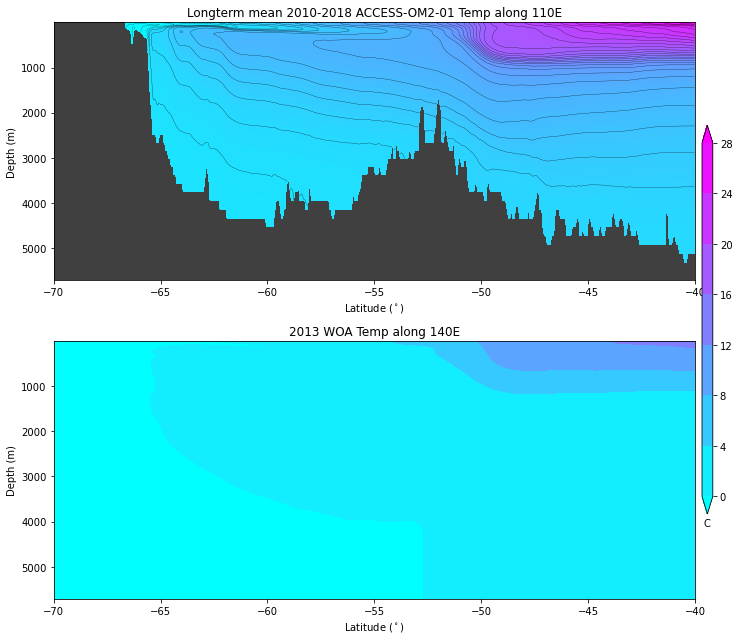

In [10]:
fig = plt.figure(figsize=(10, 9))

clev = np.arange(-2,15,.1)
clev2 = np.arange(-2,15,0.5)

lon2=-220

var=temp.sel(xt_ocean=lon2, method='nearest').mean(dim='time')

plt.subplot(2,1,1)
plt.gca().patch.set_color('.25')
p1=plt.contourf(var.yt_ocean,var.st_ocean,var-273.13,levels=clev,cmap=plt.cm.cool,colobar=True,extend='both')
plt.contour(var.yt_ocean,var.st_ocean,var-273.13,levels=clev2,colors='k',linewidths=0.25)
plt.gca().invert_yaxis()
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-70,-40])
plt.title('Longterm mean 2010-2018 ACCESS-OM2-01 Temp along 110E')

var=woa13.temp.sel(GRID_X_T=lon2, method='nearest').mean(dim='time')

plt.subplot(2,1,2)
plt.gca().patch.set_color('.25')
p1=plt.contourf(var.GRID_Y_T,var.ZT,var.values,cmap=plt.cm.cool,colobar=False,extend='both')
plt.gca().invert_yaxis()
#plt.ylim((1037.5,1034))
plt.ylabel('Depth (m)')
plt.xlabel('Latitude ($^\circ$)')
plt.xlim([-70,-40])
plt.title('2013 WOA Temp along 140E')

#horiz, vert, width,height
ax = plt.axes([0.98,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('C')

plt.tight_layout()

Why does the WOA on model grid data look so cold?

In [11]:
#longterm monthly mean data at 110E
var=temp.sel(xt_ocean=lon2, method='nearest').groupby('time.month').mean(dim='time') #.resample({'time':'M'})
var

<xarray.DataArray 'temp' (month: 12, st_ocean: 75, yt_ocean: 808)>
dask.array<stack, shape=(12, 75, 808), dtype=float32, chunksize=(1, 25, 135), chunktype=numpy.ndarray>
Coordinates:
    xt_ocean  float64 -220.0
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -40.18 -40.11 -40.03
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

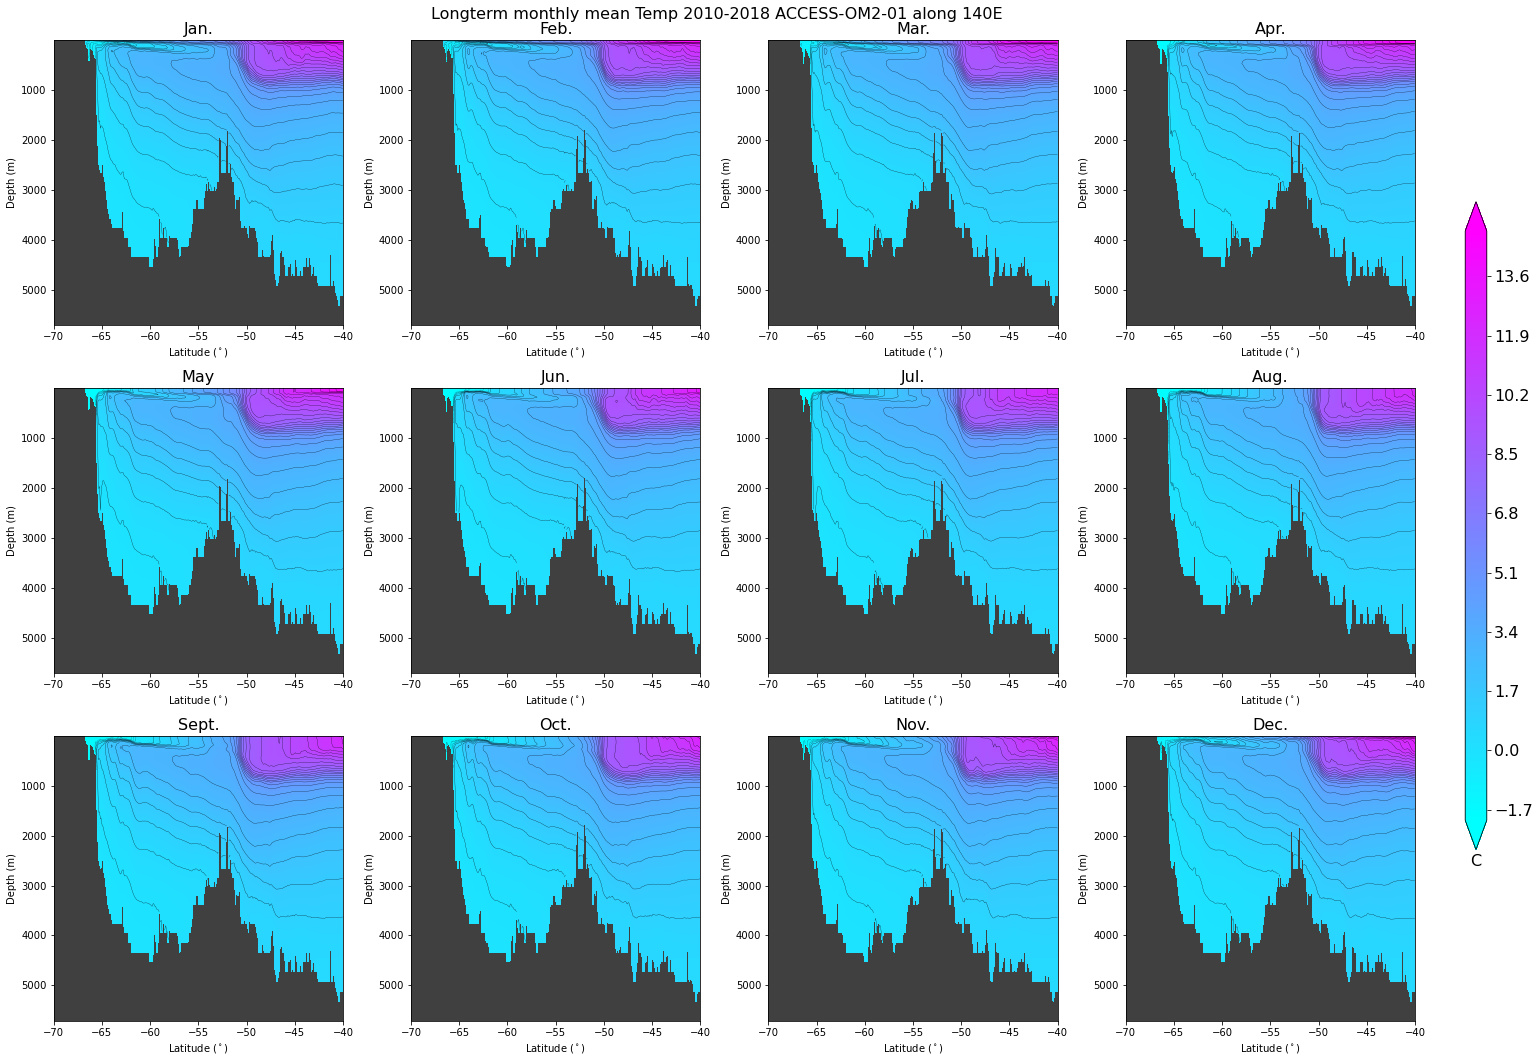

In [12]:
mnth=['Jan.', 'Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.']
plt.figure(figsize=(20,15))
plt.suptitle('Longterm monthly mean Temp 2010-2018 ACCESS-OM2-01 along 140E',fontsize = 16)

for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(var.yt_ocean,var.st_ocean,var[i,:,:]-273.13,levels=clev,cmap=plt.cm.cool,colobar=True,extend='both')
    plt.contour(var.yt_ocean,var.st_ocean,var[i,:,:]-273.13,levels=clev2,colors='k',linewidths=0.25)
    plt.gca().invert_yaxis()
    #plt.ylim((1037.5,1034))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-70,-40])
    plt.title(mnth[i],fontsize = 16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('C',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()

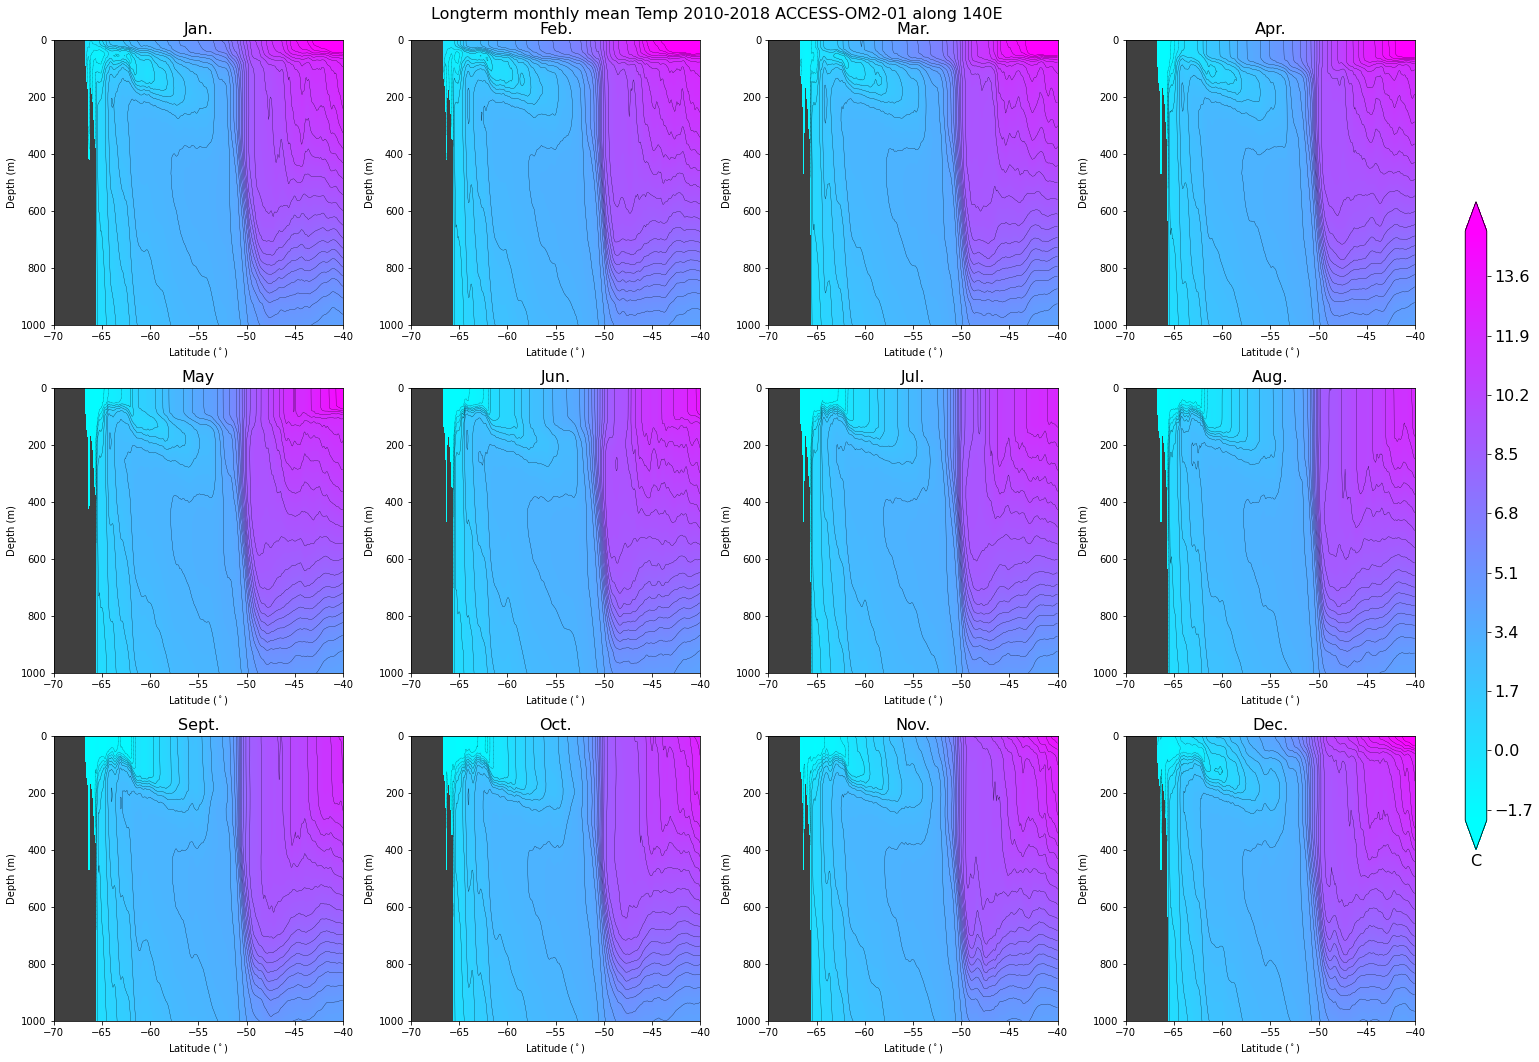

In [13]:
mnth=['Jan.', 'Feb.','Mar.','Apr.','May','Jun.','Jul.','Aug.','Sept.','Oct.','Nov.','Dec.']
plt.figure(figsize=(20,15))
plt.suptitle('Longterm monthly mean Temp 2010-2018 ACCESS-OM2-01 along 140E',fontsize=16)

for i in range(0,12):
    plt.subplot(3,4,i+1)
    plt.gca().patch.set_color('.25')
    p1=plt.contourf(var.yt_ocean,var.st_ocean,var[i,:,:]-273.13,levels=clev,cmap=plt.cm.cool,colobar=True,extend='both')
    plt.contour(var.yt_ocean,var.st_ocean,var[i,:,:]-273.13,levels=clev2,colors='k',linewidths=0.25)
    #plt.ylim((1037.5,1034))
    plt.ylabel('Depth (m)')
    plt.xlabel('Latitude ($^\circ$)')
    plt.xlim([-70,-40])
    plt.ylim([0,1000])
    plt.gca().invert_yaxis()
    plt.title(mnth[i],fontsize=16)

#horiz, vert, width,height
ax = plt.axes([1.02,0.2,0.015,0.6])
cb = plt.colorbar(p1,cax=ax,orientation='vertical',shrink=0.7)
cb.ax.set_xlabel('C',fontsize=16);
cb.ax.tick_params(labelsize=16) 

plt.tight_layout()